In [1]:
from __future__ import print_function

print(__doc__)

import numpy as np

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import pandas as pd
#------------------------------------------------------------------------

from abc import ABCMeta, abstractmethod

import numpy as np
from scipy.stats import truncnorm
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin



Automatically created module for IPython interactive environment


In [2]:
#------------------------Activation Functions----------------------------------------------------


class ActivationFunction(object):
    """
    Class for abstract activation function.
    """
    __metaclass__ = ABCMeta

    @abstractmethod
    def function(self, x):
        return

    @abstractmethod
    def prime(self, x):
        return


class SigmoidActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Sigmoid function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return 1 / (1.0 + np.exp(-x))

    @classmethod
    def prime(cls, x):
        """
        Compute sigmoid first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return x * (1 - x)


class ReLUActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Rectified linear function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return np.maximum(np.zeros(x.shape), x)

    @classmethod
    def prime(cls, x):
        """
        Rectified linear first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return (x > 0).astype(int)


class TanhActivationFunction(ActivationFunction):
    @classmethod
    def function(cls, x):
        """
        Hyperbolic tangent function.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return np.tanh(x)

    @classmethod
    def prime(cls, x):
        """
        Hyperbolic tangent first derivative.
        :param x: array-like, shape = (n_features, )
        :return:
        """
        return 1 - x * x

In [3]:
#---------------------------------Batch Generator--------------------------------------------------------



def batch_generator(batch_size, data, labels=None):
    """
    Generates batches of samples
    :param data: array-like, shape = (n_samples, n_features)
    :param labels: array-like, shape = (n_samples, )
    :return:
    """
    n_batches = int(np.ceil(len(data) / float(batch_size)))
    idx = np.random.permutation(len(data))
    data_shuffled = data[idx]
    if labels is not None:
        labels_shuffled = labels[idx]
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        if labels is not None:
            yield data_shuffled[start:end, :], labels_shuffled[start:end]
        else:
            yield data_shuffled[start:end, :]


def to_categorical(labels, num_classes):
    """
    Converts labels as single integer to row vectors. For instance, given a three class problem, labels would be
    mapped as label_1: [1 0 0], label_2: [0 1 0], label_3: [0, 0, 1] where labels can be either int or string.
    :param labels: array-like, shape = (n_samples, )
    :return:
    """
    new_labels = np.zeros([len(labels), num_classes])
    label_to_idx_map, idx_to_label_map = dict(), dict()
    idx = 0
    for i, label in enumerate(labels):
        if label not in label_to_idx_map:
            label_to_idx_map[label] = idx
            idx_to_label_map[idx] = label
            idx += 1
        new_labels[i][label_to_idx_map[label]] = 1
    return new_labels, label_to_idx_map, idx_to_label_map

In [4]:

#-----------------Base Model----------------------------------------------

class BaseModel(object):
    def save(self, save_path):
        import pickle

        with open(save_path, 'wb') as fp:
            pickle.dump(self, fp)

    @classmethod
    def load(cls, load_path):
        import pickle

        with open(load_path, 'rb') as fp:
            return pickle.load(fp)

    
    
    

    
    
    
#-------------------------------BinaryRBM---------------------------------------------------

class BinaryRBM(BaseEstimator, TransformerMixin, BaseModel):
    """
    This class implements a Binary Restricted Boltzmann machine.
    """

    def __init__(self,
                 n_hidden_units=100,
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate=1e-3,
                 n_epochs=10,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 verbose=True):
        self.n_hidden_units = n_hidden_units
        self.activation_function = activation_function
        self.optimization_algorithm = optimization_algorithm
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X):
        """
        Fit a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        # Initialize RBM parameters
        self.n_visible_units = X.shape[1]
        if self.activation_function == 'sigmoid':
            self.W = np.random.randn(self.n_hidden_units, self.n_visible_units) / np.sqrt(self.n_visible_units)
            self.c = np.random.randn(self.n_hidden_units) / np.sqrt(self.n_visible_units)
            self.b = np.random.randn(self.n_visible_units) / np.sqrt(self.n_visible_units)
            self._activation_function_class = SigmoidActivationFunction
        elif self.activation_function == 'relu':
            self.W = truncnorm.rvs(-0.2, 0.2, size=[self.n_hidden_units, self.n_visible_units]) / np.sqrt(
                self.n_visible_units)
            self.c = np.full(self.n_hidden_units, 0.1) / np.sqrt(self.n_visible_units)
            self.b = np.full(self.n_visible_units, 0.1) / np.sqrt(self.n_visible_units)
            self._activation_function_class = ReLUActivationFunction
        else:
            raise ValueError("Invalid activation function.")

        if self.optimization_algorithm == 'sgd':
            self._stochastic_gradient_descent(X)
        else:
            raise ValueError("Invalid optimization algorithm.")
        return self

    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        if len(X.shape) == 1:  # It is a single sample
            return self._compute_hidden_units(X)
        transformed_data = self._compute_hidden_units_matrix(X)
        return transformed_data

    def _reconstruct(self, transformed_data):
        """
        Reconstruct visible units given the hidden layer output.
        :param transformed_data: array-like, shape = (n_samples, n_features)
        :return:
        """
        return self._compute_visible_units_matrix(transformed_data)

    def _stochastic_gradient_descent(self, _data):
        """
        Performs stochastic gradient descend optimization algorithm.
        :param _data: array-like, shape = (n_samples, n_features)
        :return:
        """
        accum_delta_W = np.zeros(self.W.shape)
        accum_delta_b = np.zeros(self.b.shape)
        accum_delta_c = np.zeros(self.c.shape)
        for iteration in range(1, self.n_epochs + 1):
            idx = np.random.permutation(len(_data))
            data = _data[idx]
            for batch in batch_generator(self.batch_size, data):
                accum_delta_W[:] = .0
                accum_delta_b[:] = .0
                accum_delta_c[:] = .0
                for sample in batch:
                    delta_W, delta_b, delta_c = self._contrastive_divergence(sample)
                    accum_delta_W += delta_W
                    accum_delta_b += delta_b
                    accum_delta_c += delta_c
                self.W += self.learning_rate * (accum_delta_W / self.batch_size)
                self.b += self.learning_rate * (accum_delta_b / self.batch_size)
                self.c += self.learning_rate * (accum_delta_c / self.batch_size)
            if self.verbose:
                error = self._compute_reconstruction_error(data)
                print(">> Epoch %d finished \tRBM Reconstruction error %f" % (iteration, error))

    def _contrastive_divergence(self, vector_visible_units):
        """
        Computes gradients using Contrastive Divergence method.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v_0 = vector_visible_units
        v_t = np.array(v_0)

        # Sampling
        for t in range(self.contrastive_divergence_iter):
            h_t = self._sample_hidden_units(v_t)
            v_t = self._compute_visible_units(h_t)

        # Computing deltas
        v_k = v_t
        h_0 = self._compute_hidden_units(v_0)
        h_k = self._compute_hidden_units(v_k)
        delta_W = np.outer(h_0, v_0) - np.outer(h_k, v_k)
        delta_b = v_0 - v_k
        delta_c = h_0 - h_k

        return delta_W, delta_b, delta_c

    def _sample_hidden_units(self, vector_visible_units):
        """
        Computes hidden unit activations by sampling from a binomial distribution.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        hidden_units = self._compute_hidden_units(vector_visible_units)
        return (np.random.random_sample(len(hidden_units)) < hidden_units).astype(np.int64)

    def _sample_visible_units(self, vector_hidden_units):
        """
        Computes visible unit activations by sampling from a binomial distribution.
        :param vector_hidden_units: array-like, shape = (n_features, )
        :return:
        """
        visible_units = self._compute_visible_units(vector_hidden_units)
        return (np.random.random_sample(len(visible_units)) < visible_units).astype(np.int64)

    def _compute_hidden_units(self, vector_visible_units):
        """
        Computes hidden unit outputs.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = np.expand_dims(vector_visible_units, 0)
        h = np.squeeze(self._compute_hidden_units_matrix(v))
        return np.array([h]) if not h.shape else h

    def _compute_hidden_units_matrix(self, matrix_visible_units):
        """
        Computes hidden unit outputs.
        :param matrix_visible_units: array-like, shape = (n_samples, n_features)
        :return:
        """
        return np.transpose(self._activation_function_class.function(
            np.dot(self.W, np.transpose(matrix_visible_units)) + self.c[:, np.newaxis]))

    def _compute_visible_units(self, vector_hidden_units):
        """
        Computes visible (or input) unit outputs.
        :param vector_hidden_units: array-like, shape = (n_features, )
        :return:
        """
        h = np.expand_dims(vector_hidden_units, 0)
        v = np.squeeze(self._compute_visible_units_matrix(h))
        return np.array([v]) if not v.shape else v

    def _compute_visible_units_matrix(self, matrix_hidden_units):
        """
        Computes visible (or input) unit outputs.
        :param matrix_hidden_units: array-like, shape = (n_samples, n_features)
        :return:
        """
        return self._activation_function_class.function(np.dot(matrix_hidden_units, self.W) + self.b[np.newaxis, :])

    def _compute_free_energy(self, vector_visible_units):
        """
        Computes the RBM free energy.
        :param vector_visible_units: array-like, shape = (n_features, )
        :return:
        """
        v = vector_visible_units
        return - np.dot(self.b, v) - np.sum(np.log(1 + np.exp(np.dot(self.W, v) + self.c)))

    def _compute_reconstruction_error(self, data):
        """
        Computes the reconstruction error of the data.
        :param data: array-like, shape = (n_samples, n_features)
        :return:
        """
        data_transformed = self.transform(data)
        data_reconstructed = self._reconstruct(data_transformed)
        return np.mean(np.sum((data_reconstructed - data) ** 2, 1))

#---------------------------------------Unsupervised DBN ----------------------------------------




class UnsupervisedDBN(BaseEstimator, TransformerMixin, BaseModel):
    """
    This class implements a unsupervised Deep Belief Network.
    """

    def __init__(self,
                 hidden_layers_structure=[100, 100],
                 activation_function='sigmoid',
                 optimization_algorithm='sgd',
                 learning_rate_rbm=1e-3,
                 n_epochs_rbm=10,
                 contrastive_divergence_iter=1,
                 batch_size=32,
                 verbose=True):
        self.hidden_layers_structure = hidden_layers_structure
        self.activation_function = activation_function
        self.optimization_algorithm = optimization_algorithm
        self.learning_rate_rbm = learning_rate_rbm
        self.n_epochs_rbm = n_epochs_rbm
        self.contrastive_divergence_iter = contrastive_divergence_iter
        self.batch_size = batch_size
        self.rbm_layers = None
        self.verbose = verbose
        self.rbm_class = BinaryRBM

    def fit(self, X, y=None):
        """
        Fits a model given data.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        # Initialize rbm layers
        self.rbm_layers = list()
        for n_hidden_units in self.hidden_layers_structure:
            rbm = self.rbm_class(n_hidden_units=n_hidden_units,
                                 activation_function=self.activation_function,
                                 optimization_algorithm=self.optimization_algorithm,
                                 learning_rate=self.learning_rate_rbm,
                                 n_epochs=self.n_epochs_rbm,
                                 contrastive_divergence_iter=self.contrastive_divergence_iter,
                                 batch_size=self.batch_size,
                                 verbose=self.verbose)
            self.rbm_layers.append(rbm)

        # Fit RBM
        if self.verbose:
            print("[START] Pre-training step:")
        input_data = X
        for rbm in self.rbm_layers:
            rbm.fit(input_data)
            input_data = rbm.transform(input_data)
        if self.verbose:
            print("[END] Pre-training step")
        return self

    def transform(self, X):
        """
        Transforms data using the fitted model.
        :param X: array-like, shape = (n_samples, n_features)
        :return:
        """
        input_data = X
        for rbm in self.rbm_layers:
            input_data = rbm.transform(input_data)
        return input_data

In [5]:
bugzilla = pd.read_csv("Datasets/bugzilla.csv")
scaler = MinMaxScaler()
bugzilla = bugzilla.drop(['transactionid','commitdate'],axis=1)

bugzilla =pd.DataFrame(scaler.fit_transform(bugzilla) , columns= bugzilla.columns , index=bugzilla.index)



mozilla = pd.read_csv("Datasets/mozilla.csv")
scaler = MinMaxScaler()
mozilla = mozilla.drop(['transactionid','commitdate'],axis=1)

mozilla =pd.DataFrame(scaler.fit_transform(mozilla) , columns= mozilla.columns , index=mozilla.index)



jdt = pd.read_csv("Datasets/jdt.csv")
scaler = MinMaxScaler()
jdt = jdt.drop(['transactionid','commitdate'],axis=1)

jdt =pd.DataFrame(scaler.fit_transform(jdt) , columns= jdt.columns , index=jdt.index)

class underSampling():
    def __init__(self):
        return
    def resample(self,dataset,target,values):
        print("The total is : ", dataset.shape[0])
        majority_class_len=0
        index_of_majority = 0
        
        minority_class_len=0
        index_of_minority=0
        for i in range(len(values)):
            numOfVal=dataset.query(str(target) +"==" + str(values[i])).count()[0]
            
            if majority_class_len < numOfVal:
                majority_class_len=numOfVal
                index_of_majority=i
            
            if majority_class_len > numOfVal:
                minority_class_len = numOfVal
                index_of_minority=i
            print("The class ",target,"==",values[i]," is : ", numOfVal,"-",
                 (100 * (numOfVal /float(dataset.shape[0]))).round(2) ,"% of the given dataset.")
            
        majority_class_indices=dataset[dataset[target]==index_of_majority].index
        random_majority_indices=np.random.choice(majority_class_indices,minority_class_len,replace=False)
        
        minority_class_indices=dataset[dataset[target]!=index_of_majority].index
        under_sample_indices=np.concatenate([minority_class_indices,random_majority_indices])
        
        resampled_dataset=dataset.loc[under_sample_indices]
        
        print("\n----------------------------------------------------------------------------\n")
        print("Dataset has been successfully resampled!")
        
        print("\nThe total is : ", resampled_dataset.shape[0])
        for i in range(len(values)):
            numOfVal=resampled_dataset.query(str(target) +"==" + str(values[i])).count()[0]
        
            print("The class ",target,"==",values[i]," is : ", numOfVal)
        
        return resampled_dataset
    
    

sample=underSampling()
bugzilla = sample.resample(bugzilla,"bug",[0,1])

x_data_bugzilla = bugzilla.drop('bug',axis=1)
x_data_bugzilla=x_data_bugzilla.astype('float32')
y_label_bugzilla = bugzilla['bug']
y_label_bugzilla=pd.DataFrame(y_label_bugzilla)
y_label_bugzilla=y_label_bugzilla.astype("float32")

x_data_bugzilla=x_data_bugzilla.values
y_label_bugzilla=y_label_bugzilla.values



mozilla = sample.resample(mozilla,"bug",[0,1])

x_data_mozilla = mozilla.drop('bug',axis=1)
x_data_mozilla=x_data_mozilla.astype('float32')
y_label_mozilla = mozilla['bug']
y_label_mozilla=pd.DataFrame(y_label_mozilla)
y_label_mozilla=y_label_mozilla.astype("float32")

x_data_mozilla=x_data_mozilla.values
y_label_mozilla=y_label_mozilla.values


jdt = sample.resample(jdt,"bug",[0,1])

x_data_jdt = jdt.drop('bug',axis=1)
x_data_jdt=x_data_jdt.astype('float32')
y_label_jdt = jdt['bug']
y_label_jdt=pd.DataFrame(y_label_jdt)
y_label_jdt=y_label_jdt.astype("float32")

x_data_jdt=x_data_jdt.values
y_label_jdt=y_label_jdt.values


#x_train, x_test, y_train, y_test = train_test_split(x_data, y_label, test_size=0.3, random_state=101)



The total is :  4620
The class  bug == 0  is :  2924 - 63.29 % of the given dataset.
The class  bug == 1  is :  1696 - 36.71 % of the given dataset.

----------------------------------------------------------------------------

Dataset has been successfully resampled!

The total is :  3392
The class  bug == 0  is :  1696
The class  bug == 1  is :  1696
The total is :  98275
The class  bug == 0  is :  93126 - 94.76 % of the given dataset.
The class  bug == 1  is :  5149 - 5.24 % of the given dataset.

----------------------------------------------------------------------------

Dataset has been successfully resampled!

The total is :  10298
The class  bug == 0  is :  5149
The class  bug == 1  is :  5149
The total is :  35386
The class  bug == 0  is :  30297 - 85.62 % of the given dataset.
The class  bug == 1  is :  5089 - 14.38 % of the given dataset.

----------------------------------------------------------------------------

Dataset has been successfully resampled!

The total is :  

In [6]:
from sklearn.model_selection import StratifiedKFold

logistic = linear_model.LogisticRegression()
dbn = UnsupervisedDBN(hidden_layers_structure=[12,6,2],
                      batch_size=10,
                      learning_rate_rbm=0.06,
                      n_epochs_rbm=20,
                      activation_function='sigmoid')


classifier = Pipeline(steps=[('dbn', dbn),
                             ('logistic', logistic)])

logistic_classifier = linear_model.LogisticRegression()



skf = StratifiedKFold(n_splits=10)

DBN_predicted_y_bugzilla = []
DBN_expected_y_bugzilla = []
DBN_x_test_bugzilla=[]

predicted_y_bugzilla = []
expected_y_bugzilla = []


DBN_predicted_y_mozilla = []
DBN_expected_y_mozilla = []
DBN_x_test_mozilla=[]

predicted_y_mozilla = []
expected_y_mozilla = []


DBN_predicted_y_jdt = []
DBN_expected_y_jdt = []
DBN_x_test_jdt=[]

predicted_y_jdt = []
expected_y_jdt = []

for train_index, test_index in skf.split(x_data_bugzilla, y_label_bugzilla):
    x_train, x_test = x_data_bugzilla[train_index], x_data_bugzilla[test_index]
    y_train, y_test = y_label_bugzilla[train_index], y_label_bugzilla[test_index]
    
    classifier.fit(x_train, y_train)
    
    DBN_predicted_y_bugzilla.extend(classifier.predict(x_test))
    DBN_expected_y_bugzilla.extend(y_test)
    DBN_x_test_bugzilla.extend(x_test)
    
   
    logistic_classifier.fit(x_train, y_train)
    
    # store result from classification
    predicted_y_bugzilla.extend(logistic_classifier.predict(x_test))

    # store expected result for this specific fold
    expected_y_bugzilla.extend(y_test)




for train_index, test_index in skf.split(x_data_mozilla, y_label_mozilla):
    x_train, x_test = x_data_mozilla[train_index], x_data_mozilla[test_index]
    y_train, y_test = y_label_mozilla[train_index], y_label_mozilla[test_index]
    
    classifier.fit(x_train, y_train)
    
    DBN_predicted_y_mozilla.extend(classifier.predict(x_test))
    DBN_expected_y_mozilla.extend(y_test)
    DBN_x_test_mozilla.extend(x_test)
    
    logistic_classifier = linear_model.LogisticRegression(C=100.0)
    logistic_classifier.fit(x_train, y_train)
    
    # store result from classification
    predicted_y_mozilla.extend(logistic_classifier.predict(x_test))

    # store expected result for this specific fold
    expected_y_mozilla.extend(y_test)



for train_index, test_index in skf.split(x_data_jdt, y_label_jdt):
    x_train, x_test = x_data_jdt[train_index], x_data_jdt[test_index]
    y_train, y_test = y_label_jdt[train_index], y_label_jdt[test_index]
    
    classifier.fit(x_train, y_train)
    
    DBN_predicted_y_jdt.extend(classifier.predict(x_test))
    DBN_expected_y_jdt.extend(y_test)
    DBN_x_test_jdt.extend(x_test)
    
    logistic_classifier = linear_model.LogisticRegression()
    logistic_classifier.fit(x_train, y_train)
    
    # store result from classification
    predicted_y_jdt.extend(logistic_classifier.predict(x_test))

    # store expected result for this specific fold
    expected_y_jdt.extend(y_test)


    
print("Bugzilla - Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        DBN_expected_y_bugzilla,
        DBN_predicted_y_bugzilla)))

print("Bugzilla - Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        expected_y_bugzilla,
        predicted_y_bugzilla)))


print("Mozilla - Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        DBN_expected_y_mozilla,
        DBN_predicted_y_mozilla)))

print("Mozilla - Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        expected_y_mozilla,
        predicted_y_mozilla)))

print("JDT - Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        DBN_expected_y_jdt,
        DBN_predicted_y_jdt)))

print("JDT - Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        expected_y_jdt,
        predicted_y_jdt)))



    

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.454385
>> Epoch 2 finished 	RBM Reconstruction error 0.391680
>> Epoch 3 finished 	RBM Reconstruction error 0.331600
>> Epoch 4 finished 	RBM Reconstruction error 0.280483
>> Epoch 5 finished 	RBM Reconstruction error 0.237595
>> Epoch 6 finished 	RBM Reconstruction error 0.189655
>> Epoch 7 finished 	RBM Reconstruction error 0.168479
>> Epoch 8 finished 	RBM Reconstruction error 0.148535
>> Epoch 9 finished 	RBM Reconstruction error 0.150756
>> Epoch 10 finished 	RBM Reconstruction error 0.145420
>> Epoch 11 finished 	RBM Reconstruction error 0.133020
>> Epoch 12 finished 	RBM Reconstruction error 0.125442
>> Epoch 13 finished 	RBM Reconstruction error 0.131654
>> Epoch 14 finished 	RBM Reconstruction error 0.131903
>> Epoch 15 finished 	RBM Reconstruction error 0.117571
>> Epoch 16 finished 	RBM Reconstruction error 0.124440
>> Epoch 17 finished 	RBM Reconstruction error 0.121598
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.449572
>> Epoch 2 finished 	RBM Reconstruction error 0.371893
>> Epoch 3 finished 	RBM Reconstruction error 0.301527
>> Epoch 4 finished 	RBM Reconstruction error 0.249352
>> Epoch 5 finished 	RBM Reconstruction error 0.206335
>> Epoch 6 finished 	RBM Reconstruction error 0.187320
>> Epoch 7 finished 	RBM Reconstruction error 0.154036
>> Epoch 8 finished 	RBM Reconstruction error 0.148845
>> Epoch 9 finished 	RBM Reconstruction error 0.142598
>> Epoch 10 finished 	RBM Reconstruction error 0.128574
>> Epoch 11 finished 	RBM Reconstruction error 0.132648
>> Epoch 12 finished 	RBM Reconstruction error 0.131360
>> Epoch 13 finished 	RBM Reconstruction error 0.127723
>> Epoch 14 finished 	RBM Reconstruction error 0.132210
>> Epoch 15 finished 	RBM Reconstruction error 0.125649
>> Epoch 16 finished 	RBM Reconstruction error 0.123630
>> Epoch 17 finished 	RBM Reconstruction error 0.126348
>> Epoch 18 finished 	RBM Reconstruction error 0.121761
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.451606
>> Epoch 2 finished 	RBM Reconstruction error 0.391441
>> Epoch 3 finished 	RBM Reconstruction error 0.333391
>> Epoch 4 finished 	RBM Reconstruction error 0.287755
>> Epoch 5 finished 	RBM Reconstruction error 0.239987
>> Epoch 6 finished 	RBM Reconstruction error 0.200343
>> Epoch 7 finished 	RBM Reconstruction error 0.170509
>> Epoch 8 finished 	RBM Reconstruction error 0.163522
>> Epoch 9 finished 	RBM Reconstruction error 0.148287
>> Epoch 10 finished 	RBM Reconstruction error 0.141173
>> Epoch 11 finished 	RBM Reconstruction error 0.140426
>> Epoch 12 finished 	RBM Reconstruction error 0.130393
>> Epoch 13 finished 	RBM Reconstruction error 0.130195
>> Epoch 14 finished 	RBM Reconstruction error 0.130076
>> Epoch 15 finished 	RBM Reconstruction error 0.129806
>> Epoch 16 finished 	RBM Reconstruction error 0.127189
>> Epoch 17 finished 	RBM Reconstruction error 0.125441
>> Epoch 18 finished 	RBM Reconstruction error 0.126941
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.471670
>> Epoch 2 finished 	RBM Reconstruction error 0.405868
>> Epoch 3 finished 	RBM Reconstruction error 0.328775
>> Epoch 4 finished 	RBM Reconstruction error 0.283025
>> Epoch 5 finished 	RBM Reconstruction error 0.248344
>> Epoch 6 finished 	RBM Reconstruction error 0.214568
>> Epoch 7 finished 	RBM Reconstruction error 0.176707
>> Epoch 8 finished 	RBM Reconstruction error 0.154420
>> Epoch 9 finished 	RBM Reconstruction error 0.137983
>> Epoch 10 finished 	RBM Reconstruction error 0.134304
>> Epoch 11 finished 	RBM Reconstruction error 0.126360
>> Epoch 12 finished 	RBM Reconstruction error 0.133167
>> Epoch 13 finished 	RBM Reconstruction error 0.122348
>> Epoch 14 finished 	RBM Reconstruction error 0.119828
>> Epoch 15 finished 	RBM Reconstruction error 0.118337
>> Epoch 16 finished 	RBM Reconstruction error 0.124004
>> Epoch 17 finished 	RBM Reconstruction error 0.126761
>> Epoch 18 finished 	RBM Reconstruction error 0.113970
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.464697
>> Epoch 2 finished 	RBM Reconstruction error 0.388609
>> Epoch 3 finished 	RBM Reconstruction error 0.314856
>> Epoch 4 finished 	RBM Reconstruction error 0.251989
>> Epoch 5 finished 	RBM Reconstruction error 0.208731
>> Epoch 6 finished 	RBM Reconstruction error 0.183096
>> Epoch 7 finished 	RBM Reconstruction error 0.167255
>> Epoch 8 finished 	RBM Reconstruction error 0.152392
>> Epoch 9 finished 	RBM Reconstruction error 0.143067
>> Epoch 10 finished 	RBM Reconstruction error 0.139093
>> Epoch 11 finished 	RBM Reconstruction error 0.135115
>> Epoch 12 finished 	RBM Reconstruction error 0.137256
>> Epoch 13 finished 	RBM Reconstruction error 0.137735
>> Epoch 14 finished 	RBM Reconstruction error 0.132916
>> Epoch 15 finished 	RBM Reconstruction error 0.128127
>> Epoch 16 finished 	RBM Reconstruction error 0.126136
>> Epoch 17 finished 	RBM Reconstruction error 0.121031
>> Epoch 18 finished 	RBM Reconstruction error 0.120757
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.439146
>> Epoch 2 finished 	RBM Reconstruction error 0.348670
>> Epoch 3 finished 	RBM Reconstruction error 0.305653
>> Epoch 4 finished 	RBM Reconstruction error 0.262448
>> Epoch 5 finished 	RBM Reconstruction error 0.235484
>> Epoch 6 finished 	RBM Reconstruction error 0.208214
>> Epoch 7 finished 	RBM Reconstruction error 0.189290
>> Epoch 8 finished 	RBM Reconstruction error 0.157830
>> Epoch 9 finished 	RBM Reconstruction error 0.140199
>> Epoch 10 finished 	RBM Reconstruction error 0.147981
>> Epoch 11 finished 	RBM Reconstruction error 0.122563
>> Epoch 12 finished 	RBM Reconstruction error 0.120610
>> Epoch 13 finished 	RBM Reconstruction error 0.116436
>> Epoch 14 finished 	RBM Reconstruction error 0.121976
>> Epoch 15 finished 	RBM Reconstruction error 0.118250
>> Epoch 16 finished 	RBM Reconstruction error 0.126775
>> Epoch 17 finished 	RBM Reconstruction error 0.115685
>> Epoch 18 finished 	RBM Reconstruction error 0.121948
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.453731
>> Epoch 2 finished 	RBM Reconstruction error 0.385814
>> Epoch 3 finished 	RBM Reconstruction error 0.329267
>> Epoch 4 finished 	RBM Reconstruction error 0.260297
>> Epoch 5 finished 	RBM Reconstruction error 0.211004
>> Epoch 6 finished 	RBM Reconstruction error 0.195079
>> Epoch 7 finished 	RBM Reconstruction error 0.161071
>> Epoch 8 finished 	RBM Reconstruction error 0.142345
>> Epoch 9 finished 	RBM Reconstruction error 0.133897
>> Epoch 10 finished 	RBM Reconstruction error 0.140553
>> Epoch 11 finished 	RBM Reconstruction error 0.132840
>> Epoch 12 finished 	RBM Reconstruction error 0.131192
>> Epoch 13 finished 	RBM Reconstruction error 0.131256
>> Epoch 14 finished 	RBM Reconstruction error 0.121144
>> Epoch 15 finished 	RBM Reconstruction error 0.123371
>> Epoch 16 finished 	RBM Reconstruction error 0.121486
>> Epoch 17 finished 	RBM Reconstruction error 0.120012
>> Epoch 18 finished 	RBM Reconstruction error 0.119695
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.433828
>> Epoch 2 finished 	RBM Reconstruction error 0.374011
>> Epoch 3 finished 	RBM Reconstruction error 0.289612
>> Epoch 4 finished 	RBM Reconstruction error 0.245224
>> Epoch 5 finished 	RBM Reconstruction error 0.208405
>> Epoch 6 finished 	RBM Reconstruction error 0.179420
>> Epoch 7 finished 	RBM Reconstruction error 0.157134
>> Epoch 8 finished 	RBM Reconstruction error 0.144726
>> Epoch 9 finished 	RBM Reconstruction error 0.140725
>> Epoch 10 finished 	RBM Reconstruction error 0.134891
>> Epoch 11 finished 	RBM Reconstruction error 0.135069
>> Epoch 12 finished 	RBM Reconstruction error 0.132472
>> Epoch 13 finished 	RBM Reconstruction error 0.132123
>> Epoch 14 finished 	RBM Reconstruction error 0.128155
>> Epoch 15 finished 	RBM Reconstruction error 0.128586
>> Epoch 16 finished 	RBM Reconstruction error 0.124276
>> Epoch 17 finished 	RBM Reconstruction error 0.123369
>> Epoch 18 finished 	RBM Reconstruction error 0.124276
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.467447
>> Epoch 2 finished 	RBM Reconstruction error 0.397351
>> Epoch 3 finished 	RBM Reconstruction error 0.320181
>> Epoch 4 finished 	RBM Reconstruction error 0.254570
>> Epoch 5 finished 	RBM Reconstruction error 0.218861
>> Epoch 6 finished 	RBM Reconstruction error 0.175692
>> Epoch 7 finished 	RBM Reconstruction error 0.163058
>> Epoch 8 finished 	RBM Reconstruction error 0.148295
>> Epoch 9 finished 	RBM Reconstruction error 0.141301
>> Epoch 10 finished 	RBM Reconstruction error 0.132843
>> Epoch 11 finished 	RBM Reconstruction error 0.130335
>> Epoch 12 finished 	RBM Reconstruction error 0.133013
>> Epoch 13 finished 	RBM Reconstruction error 0.130247
>> Epoch 14 finished 	RBM Reconstruction error 0.129636
>> Epoch 15 finished 	RBM Reconstruction error 0.121660
>> Epoch 16 finished 	RBM Reconstruction error 0.119294
>> Epoch 17 finished 	RBM Reconstruction error 0.127603
>> Epoch 18 finished 	RBM Reconstruction error 0.114287
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.461048
>> Epoch 2 finished 	RBM Reconstruction error 0.389200
>> Epoch 3 finished 	RBM Reconstruction error 0.314916
>> Epoch 4 finished 	RBM Reconstruction error 0.252666
>> Epoch 5 finished 	RBM Reconstruction error 0.206618
>> Epoch 6 finished 	RBM Reconstruction error 0.174487
>> Epoch 7 finished 	RBM Reconstruction error 0.143855
>> Epoch 8 finished 	RBM Reconstruction error 0.142519
>> Epoch 9 finished 	RBM Reconstruction error 0.136267
>> Epoch 10 finished 	RBM Reconstruction error 0.136983
>> Epoch 11 finished 	RBM Reconstruction error 0.140140
>> Epoch 12 finished 	RBM Reconstruction error 0.135001
>> Epoch 13 finished 	RBM Reconstruction error 0.130510
>> Epoch 14 finished 	RBM Reconstruction error 0.124445
>> Epoch 15 finished 	RBM Reconstruction error 0.122631
>> Epoch 16 finished 	RBM Reconstruction error 0.120602
>> Epoch 17 finished 	RBM Reconstruction error 0.121497
>> Epoch 18 finished 	RBM Reconstruction error 0.116900
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.134268
>> Epoch 2 finished 	RBM Reconstruction error 0.098693
>> Epoch 3 finished 	RBM Reconstruction error 0.093783
>> Epoch 4 finished 	RBM Reconstruction error 0.086186
>> Epoch 5 finished 	RBM Reconstruction error 0.083585
>> Epoch 6 finished 	RBM Reconstruction error 0.083195
>> Epoch 7 finished 	RBM Reconstruction error 0.073922
>> Epoch 8 finished 	RBM Reconstruction error 0.069640
>> Epoch 9 finished 	RBM Reconstruction error 0.069980
>> Epoch 10 finished 	RBM Reconstruction error 0.067942
>> Epoch 11 finished 	RBM Reconstruction error 0.067069
>> Epoch 12 finished 	RBM Reconstruction error 0.074762
>> Epoch 13 finished 	RBM Reconstruction error 0.072006
>> Epoch 14 finished 	RBM Reconstruction error 0.070269
>> Epoch 15 finished 	RBM Reconstruction error 0.062384
>> Epoch 16 finished 	RBM Reconstruction error 0.065178
>> Epoch 17 finished 	RBM Reconstruction error 0.065487
>> Epoch 18 finished 	RBM Reconstruction error 0.068924
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.133682
>> Epoch 2 finished 	RBM Reconstruction error 0.097482
>> Epoch 3 finished 	RBM Reconstruction error 0.090178
>> Epoch 4 finished 	RBM Reconstruction error 0.083262
>> Epoch 5 finished 	RBM Reconstruction error 0.082978
>> Epoch 6 finished 	RBM Reconstruction error 0.082124
>> Epoch 7 finished 	RBM Reconstruction error 0.079823
>> Epoch 8 finished 	RBM Reconstruction error 0.080515
>> Epoch 9 finished 	RBM Reconstruction error 0.078021
>> Epoch 10 finished 	RBM Reconstruction error 0.078256
>> Epoch 11 finished 	RBM Reconstruction error 0.076514
>> Epoch 12 finished 	RBM Reconstruction error 0.073720
>> Epoch 13 finished 	RBM Reconstruction error 0.077750
>> Epoch 14 finished 	RBM Reconstruction error 0.070521
>> Epoch 15 finished 	RBM Reconstruction error 0.079702
>> Epoch 16 finished 	RBM Reconstruction error 0.069948
>> Epoch 17 finished 	RBM Reconstruction error 0.068360
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.139642
>> Epoch 2 finished 	RBM Reconstruction error 0.097902
>> Epoch 3 finished 	RBM Reconstruction error 0.094103
>> Epoch 4 finished 	RBM Reconstruction error 0.089065
>> Epoch 5 finished 	RBM Reconstruction error 0.084720
>> Epoch 6 finished 	RBM Reconstruction error 0.082671
>> Epoch 7 finished 	RBM Reconstruction error 0.075766
>> Epoch 8 finished 	RBM Reconstruction error 0.079150
>> Epoch 9 finished 	RBM Reconstruction error 0.072956
>> Epoch 10 finished 	RBM Reconstruction error 0.075731
>> Epoch 11 finished 	RBM Reconstruction error 0.068421
>> Epoch 12 finished 	RBM Reconstruction error 0.077814
>> Epoch 13 finished 	RBM Reconstruction error 0.075378
>> Epoch 14 finished 	RBM Reconstruction error 0.077727
>> Epoch 15 finished 	RBM Reconstruction error 0.074262
>> Epoch 16 finished 	RBM Reconstruction error 0.068973
>> Epoch 17 finished 	RBM Reconstruction error 0.072109
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.140560
>> Epoch 2 finished 	RBM Reconstruction error 0.104018
>> Epoch 3 finished 	RBM Reconstruction error 0.092439
>> Epoch 4 finished 	RBM Reconstruction error 0.090230
>> Epoch 5 finished 	RBM Reconstruction error 0.089663
>> Epoch 6 finished 	RBM Reconstruction error 0.086602
>> Epoch 7 finished 	RBM Reconstruction error 0.078532
>> Epoch 8 finished 	RBM Reconstruction error 0.080220
>> Epoch 9 finished 	RBM Reconstruction error 0.080674
>> Epoch 10 finished 	RBM Reconstruction error 0.074356
>> Epoch 11 finished 	RBM Reconstruction error 0.073267
>> Epoch 12 finished 	RBM Reconstruction error 0.070011
>> Epoch 13 finished 	RBM Reconstruction error 0.072819
>> Epoch 14 finished 	RBM Reconstruction error 0.065959
>> Epoch 15 finished 	RBM Reconstruction error 0.069517
>> Epoch 16 finished 	RBM Reconstruction error 0.069478
>> Epoch 17 finished 	RBM Reconstruction error 0.069058
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.195001
>> Epoch 2 finished 	RBM Reconstruction error 0.102053
>> Epoch 3 finished 	RBM Reconstruction error 0.090222
>> Epoch 4 finished 	RBM Reconstruction error 0.084700
>> Epoch 5 finished 	RBM Reconstruction error 0.085818
>> Epoch 6 finished 	RBM Reconstruction error 0.078661
>> Epoch 7 finished 	RBM Reconstruction error 0.074983
>> Epoch 8 finished 	RBM Reconstruction error 0.078321
>> Epoch 9 finished 	RBM Reconstruction error 0.075951
>> Epoch 10 finished 	RBM Reconstruction error 0.071813
>> Epoch 11 finished 	RBM Reconstruction error 0.076153
>> Epoch 12 finished 	RBM Reconstruction error 0.070560
>> Epoch 13 finished 	RBM Reconstruction error 0.071121
>> Epoch 14 finished 	RBM Reconstruction error 0.067846
>> Epoch 15 finished 	RBM Reconstruction error 0.071216
>> Epoch 16 finished 	RBM Reconstruction error 0.066337
>> Epoch 17 finished 	RBM Reconstruction error 0.063971
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.163343
>> Epoch 2 finished 	RBM Reconstruction error 0.105666
>> Epoch 3 finished 	RBM Reconstruction error 0.095856
>> Epoch 4 finished 	RBM Reconstruction error 0.090069
>> Epoch 5 finished 	RBM Reconstruction error 0.090329
>> Epoch 6 finished 	RBM Reconstruction error 0.088888
>> Epoch 7 finished 	RBM Reconstruction error 0.083612
>> Epoch 8 finished 	RBM Reconstruction error 0.085955
>> Epoch 9 finished 	RBM Reconstruction error 0.080603
>> Epoch 10 finished 	RBM Reconstruction error 0.078876
>> Epoch 11 finished 	RBM Reconstruction error 0.075439
>> Epoch 12 finished 	RBM Reconstruction error 0.075260
>> Epoch 13 finished 	RBM Reconstruction error 0.067491
>> Epoch 14 finished 	RBM Reconstruction error 0.072014
>> Epoch 15 finished 	RBM Reconstruction error 0.070271
>> Epoch 16 finished 	RBM Reconstruction error 0.071027
>> Epoch 17 finished 	RBM Reconstruction error 0.069946
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.196283
>> Epoch 2 finished 	RBM Reconstruction error 0.106919
>> Epoch 3 finished 	RBM Reconstruction error 0.099184
>> Epoch 4 finished 	RBM Reconstruction error 0.090425
>> Epoch 5 finished 	RBM Reconstruction error 0.091119
>> Epoch 6 finished 	RBM Reconstruction error 0.087320
>> Epoch 7 finished 	RBM Reconstruction error 0.083505
>> Epoch 8 finished 	RBM Reconstruction error 0.078029
>> Epoch 9 finished 	RBM Reconstruction error 0.084257
>> Epoch 10 finished 	RBM Reconstruction error 0.079496
>> Epoch 11 finished 	RBM Reconstruction error 0.079820
>> Epoch 12 finished 	RBM Reconstruction error 0.073683
>> Epoch 13 finished 	RBM Reconstruction error 0.072941
>> Epoch 14 finished 	RBM Reconstruction error 0.069734
>> Epoch 15 finished 	RBM Reconstruction error 0.068106
>> Epoch 16 finished 	RBM Reconstruction error 0.070514
>> Epoch 17 finished 	RBM Reconstruction error 0.072613
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.150698
>> Epoch 2 finished 	RBM Reconstruction error 0.096497
>> Epoch 3 finished 	RBM Reconstruction error 0.097947
>> Epoch 4 finished 	RBM Reconstruction error 0.087346
>> Epoch 5 finished 	RBM Reconstruction error 0.087555
>> Epoch 6 finished 	RBM Reconstruction error 0.089516
>> Epoch 7 finished 	RBM Reconstruction error 0.078044
>> Epoch 8 finished 	RBM Reconstruction error 0.075180
>> Epoch 9 finished 	RBM Reconstruction error 0.075502
>> Epoch 10 finished 	RBM Reconstruction error 0.080139
>> Epoch 11 finished 	RBM Reconstruction error 0.076851
>> Epoch 12 finished 	RBM Reconstruction error 0.069654
>> Epoch 13 finished 	RBM Reconstruction error 0.069998
>> Epoch 14 finished 	RBM Reconstruction error 0.066985
>> Epoch 15 finished 	RBM Reconstruction error 0.074301
>> Epoch 16 finished 	RBM Reconstruction error 0.074238
>> Epoch 17 finished 	RBM Reconstruction error 0.073268
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.157203
>> Epoch 2 finished 	RBM Reconstruction error 0.107902
>> Epoch 3 finished 	RBM Reconstruction error 0.094017
>> Epoch 4 finished 	RBM Reconstruction error 0.091572
>> Epoch 5 finished 	RBM Reconstruction error 0.091195
>> Epoch 6 finished 	RBM Reconstruction error 0.089512
>> Epoch 7 finished 	RBM Reconstruction error 0.080034
>> Epoch 8 finished 	RBM Reconstruction error 0.079977
>> Epoch 9 finished 	RBM Reconstruction error 0.083113
>> Epoch 10 finished 	RBM Reconstruction error 0.076306
>> Epoch 11 finished 	RBM Reconstruction error 0.073870
>> Epoch 12 finished 	RBM Reconstruction error 0.071216
>> Epoch 13 finished 	RBM Reconstruction error 0.071926
>> Epoch 14 finished 	RBM Reconstruction error 0.070761
>> Epoch 15 finished 	RBM Reconstruction error 0.066437
>> Epoch 16 finished 	RBM Reconstruction error 0.075368
>> Epoch 17 finished 	RBM Reconstruction error 0.071721
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.152246
>> Epoch 2 finished 	RBM Reconstruction error 0.097945
>> Epoch 3 finished 	RBM Reconstruction error 0.095859
>> Epoch 4 finished 	RBM Reconstruction error 0.092330
>> Epoch 5 finished 	RBM Reconstruction error 0.088781
>> Epoch 6 finished 	RBM Reconstruction error 0.084611
>> Epoch 7 finished 	RBM Reconstruction error 0.080967
>> Epoch 8 finished 	RBM Reconstruction error 0.074678
>> Epoch 9 finished 	RBM Reconstruction error 0.076511
>> Epoch 10 finished 	RBM Reconstruction error 0.068241
>> Epoch 11 finished 	RBM Reconstruction error 0.066842
>> Epoch 12 finished 	RBM Reconstruction error 0.074630
>> Epoch 13 finished 	RBM Reconstruction error 0.074095
>> Epoch 14 finished 	RBM Reconstruction error 0.064837
>> Epoch 15 finished 	RBM Reconstruction error 0.067236
>> Epoch 16 finished 	RBM Reconstruction error 0.060699
>> Epoch 17 finished 	RBM Reconstruction error 0.069116
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.173669
>> Epoch 2 finished 	RBM Reconstruction error 0.134389
>> Epoch 3 finished 	RBM Reconstruction error 0.111663
>> Epoch 4 finished 	RBM Reconstruction error 0.111685
>> Epoch 5 finished 	RBM Reconstruction error 0.102602
>> Epoch 6 finished 	RBM Reconstruction error 0.095807
>> Epoch 7 finished 	RBM Reconstruction error 0.091241
>> Epoch 8 finished 	RBM Reconstruction error 0.094556
>> Epoch 9 finished 	RBM Reconstruction error 0.087516
>> Epoch 10 finished 	RBM Reconstruction error 0.080072
>> Epoch 11 finished 	RBM Reconstruction error 0.079562
>> Epoch 12 finished 	RBM Reconstruction error 0.081800
>> Epoch 13 finished 	RBM Reconstruction error 0.083084
>> Epoch 14 finished 	RBM Reconstruction error 0.071394
>> Epoch 15 finished 	RBM Reconstruction error 0.073815
>> Epoch 16 finished 	RBM Reconstruction error 0.073389
>> Epoch 17 finished 	RBM Reconstruction error 0.077232
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.193528
>> Epoch 2 finished 	RBM Reconstruction error 0.116296
>> Epoch 3 finished 	RBM Reconstruction error 0.109350
>> Epoch 4 finished 	RBM Reconstruction error 0.104442
>> Epoch 5 finished 	RBM Reconstruction error 0.099484
>> Epoch 6 finished 	RBM Reconstruction error 0.092353
>> Epoch 7 finished 	RBM Reconstruction error 0.097262
>> Epoch 8 finished 	RBM Reconstruction error 0.085704
>> Epoch 9 finished 	RBM Reconstruction error 0.085797
>> Epoch 10 finished 	RBM Reconstruction error 0.086203
>> Epoch 11 finished 	RBM Reconstruction error 0.083146
>> Epoch 12 finished 	RBM Reconstruction error 0.079420
>> Epoch 13 finished 	RBM Reconstruction error 0.076419
>> Epoch 14 finished 	RBM Reconstruction error 0.083452
>> Epoch 15 finished 	RBM Reconstruction error 0.080225
>> Epoch 16 finished 	RBM Reconstruction error 0.086336
>> Epoch 17 finished 	RBM Reconstruction error 0.074835
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.177879
>> Epoch 2 finished 	RBM Reconstruction error 0.129739
>> Epoch 3 finished 	RBM Reconstruction error 0.114007
>> Epoch 4 finished 	RBM Reconstruction error 0.107074
>> Epoch 5 finished 	RBM Reconstruction error 0.099261
>> Epoch 6 finished 	RBM Reconstruction error 0.095467
>> Epoch 7 finished 	RBM Reconstruction error 0.092769
>> Epoch 8 finished 	RBM Reconstruction error 0.089599
>> Epoch 9 finished 	RBM Reconstruction error 0.086589
>> Epoch 10 finished 	RBM Reconstruction error 0.085655
>> Epoch 11 finished 	RBM Reconstruction error 0.082926
>> Epoch 12 finished 	RBM Reconstruction error 0.079060
>> Epoch 13 finished 	RBM Reconstruction error 0.081013
>> Epoch 14 finished 	RBM Reconstruction error 0.084275
>> Epoch 15 finished 	RBM Reconstruction error 0.080451
>> Epoch 16 finished 	RBM Reconstruction error 0.079964
>> Epoch 17 finished 	RBM Reconstruction error 0.073247
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.203011
>> Epoch 2 finished 	RBM Reconstruction error 0.124155
>> Epoch 3 finished 	RBM Reconstruction error 0.103307
>> Epoch 4 finished 	RBM Reconstruction error 0.104422
>> Epoch 5 finished 	RBM Reconstruction error 0.099831
>> Epoch 6 finished 	RBM Reconstruction error 0.095995
>> Epoch 7 finished 	RBM Reconstruction error 0.099801
>> Epoch 8 finished 	RBM Reconstruction error 0.085107
>> Epoch 9 finished 	RBM Reconstruction error 0.087163
>> Epoch 10 finished 	RBM Reconstruction error 0.084301
>> Epoch 11 finished 	RBM Reconstruction error 0.084312
>> Epoch 12 finished 	RBM Reconstruction error 0.079562
>> Epoch 13 finished 	RBM Reconstruction error 0.077567
>> Epoch 14 finished 	RBM Reconstruction error 0.078576
>> Epoch 15 finished 	RBM Reconstruction error 0.085680
>> Epoch 16 finished 	RBM Reconstruction error 0.075623
>> Epoch 17 finished 	RBM Reconstruction error 0.083414
>> Epoch 18 finished 	RBM Reconstruction error 0.078594
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.186541
>> Epoch 2 finished 	RBM Reconstruction error 0.120707
>> Epoch 3 finished 	RBM Reconstruction error 0.103016
>> Epoch 4 finished 	RBM Reconstruction error 0.100882
>> Epoch 5 finished 	RBM Reconstruction error 0.093458
>> Epoch 6 finished 	RBM Reconstruction error 0.096997
>> Epoch 7 finished 	RBM Reconstruction error 0.088055
>> Epoch 8 finished 	RBM Reconstruction error 0.093229
>> Epoch 9 finished 	RBM Reconstruction error 0.089387
>> Epoch 10 finished 	RBM Reconstruction error 0.087314
>> Epoch 11 finished 	RBM Reconstruction error 0.084374
>> Epoch 12 finished 	RBM Reconstruction error 0.086935
>> Epoch 13 finished 	RBM Reconstruction error 0.083730
>> Epoch 14 finished 	RBM Reconstruction error 0.076122
>> Epoch 15 finished 	RBM Reconstruction error 0.080404
>> Epoch 16 finished 	RBM Reconstruction error 0.077526
>> Epoch 17 finished 	RBM Reconstruction error 0.079859
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.206634
>> Epoch 2 finished 	RBM Reconstruction error 0.129864
>> Epoch 3 finished 	RBM Reconstruction error 0.111248
>> Epoch 4 finished 	RBM Reconstruction error 0.100533
>> Epoch 5 finished 	RBM Reconstruction error 0.100437
>> Epoch 6 finished 	RBM Reconstruction error 0.092324
>> Epoch 7 finished 	RBM Reconstruction error 0.088362
>> Epoch 8 finished 	RBM Reconstruction error 0.087198
>> Epoch 9 finished 	RBM Reconstruction error 0.084317
>> Epoch 10 finished 	RBM Reconstruction error 0.084375
>> Epoch 11 finished 	RBM Reconstruction error 0.083415
>> Epoch 12 finished 	RBM Reconstruction error 0.083476
>> Epoch 13 finished 	RBM Reconstruction error 0.080989
>> Epoch 14 finished 	RBM Reconstruction error 0.080209
>> Epoch 15 finished 	RBM Reconstruction error 0.078173
>> Epoch 16 finished 	RBM Reconstruction error 0.080028
>> Epoch 17 finished 	RBM Reconstruction error 0.079569
>> Epoch 18 finished 	RBM Reconstruction error 0.075636
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


>> Epoch 1 finished 	RBM Reconstruction error 0.197248
>> Epoch 2 finished 	RBM Reconstruction error 0.123195
>> Epoch 3 finished 	RBM Reconstruction error 0.111236
>> Epoch 4 finished 	RBM Reconstruction error 0.099439
>> Epoch 5 finished 	RBM Reconstruction error 0.099039
>> Epoch 6 finished 	RBM Reconstruction error 0.096764
>> Epoch 7 finished 	RBM Reconstruction error 0.094568
>> Epoch 8 finished 	RBM Reconstruction error 0.084940
>> Epoch 9 finished 	RBM Reconstruction error 0.083269
>> Epoch 10 finished 	RBM Reconstruction error 0.087406
>> Epoch 11 finished 	RBM Reconstruction error 0.077028
>> Epoch 12 finished 	RBM Reconstruction error 0.086488
>> Epoch 13 finished 	RBM Reconstruction error 0.083685
>> Epoch 14 finished 	RBM Reconstruction error 0.083099
>> Epoch 15 finished 	RBM Reconstruction error 0.083114
>> Epoch 16 finished 	RBM Reconstruction error 0.081674
>> Epoch 17 finished 	RBM Reconstruction error 0.076884
>> Epoch 18 finished 	RBM Reconstruction error 0.085046
>

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.237550
>> Epoch 2 finished 	RBM Reconstruction error 0.130683
>> Epoch 3 finished 	RBM Reconstruction error 0.110335
>> Epoch 4 finished 	RBM Reconstruction error 0.097732
>> Epoch 5 finished 	RBM Reconstruction error 0.099417
>> Epoch 6 finished 	RBM Reconstruction error 0.092001
>> Epoch 7 finished 	RBM Reconstruction error 0.088525
>> Epoch 8 finished 	RBM Reconstruction error 0.082923
>> Epoch 9 finished 	RBM Reconstruction error 0.083670
>> Epoch 10 finished 	RBM Reconstruction error 0.084631
>> Epoch 11 finished 	RBM Reconstruction error 0.081787
>> Epoch 12 finished 	RBM Reconstruction error 0.076480
>> Epoch 13 finished 	RBM Reconstruction error 0.083917
>> Epoch 14 finished 	RBM Reconstruction error 0.082184
>> Epoch 15 finished 	RBM Reconstruction error 0.079404
>> Epoch 16 finished 	RBM Reconstruction error 0.078485
>> Epoch 17 finished 	RBM Reconstruction error 0.078984
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.203043
>> Epoch 2 finished 	RBM Reconstruction error 0.124539
>> Epoch 3 finished 	RBM Reconstruction error 0.110652
>> Epoch 4 finished 	RBM Reconstruction error 0.099542
>> Epoch 5 finished 	RBM Reconstruction error 0.098990
>> Epoch 6 finished 	RBM Reconstruction error 0.089987
>> Epoch 7 finished 	RBM Reconstruction error 0.091850
>> Epoch 8 finished 	RBM Reconstruction error 0.093273
>> Epoch 9 finished 	RBM Reconstruction error 0.088208
>> Epoch 10 finished 	RBM Reconstruction error 0.085809
>> Epoch 11 finished 	RBM Reconstruction error 0.076192
>> Epoch 12 finished 	RBM Reconstruction error 0.076332
>> Epoch 13 finished 	RBM Reconstruction error 0.079703
>> Epoch 14 finished 	RBM Reconstruction error 0.081903
>> Epoch 15 finished 	RBM Reconstruction error 0.076896
>> Epoch 16 finished 	RBM Reconstruction error 0.079047
>> Epoch 17 finished 	RBM Reconstruction error 0.077619
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 0.199682
>> Epoch 2 finished 	RBM Reconstruction error 0.125940
>> Epoch 3 finished 	RBM Reconstruction error 0.115984
>> Epoch 4 finished 	RBM Reconstruction error 0.101871
>> Epoch 5 finished 	RBM Reconstruction error 0.098705
>> Epoch 6 finished 	RBM Reconstruction error 0.094659
>> Epoch 7 finished 	RBM Reconstruction error 0.099345
>> Epoch 8 finished 	RBM Reconstruction error 0.092225
>> Epoch 9 finished 	RBM Reconstruction error 0.093389
>> Epoch 10 finished 	RBM Reconstruction error 0.085777
>> Epoch 11 finished 	RBM Reconstruction error 0.089112
>> Epoch 12 finished 	RBM Reconstruction error 0.085890
>> Epoch 13 finished 	RBM Reconstruction error 0.088124
>> Epoch 14 finished 	RBM Reconstruction error 0.091028
>> Epoch 15 finished 	RBM Reconstruction error 0.081526
>> Epoch 16 finished 	RBM Reconstruction error 0.080235
>> Epoch 17 finished 	RBM Reconstruction error 0.081352
>> Epoch 18 finished 	RBM Reco

/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/maros/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Bugzilla - Logistic regression using RBM features:
              precision    recall  f1-score   support

         0.0       0.59      0.84      0.69      1696
         1.0       0.73      0.41      0.52      1696

    accuracy                           0.63      3392
   macro avg       0.66      0.63      0.61      3392
weighted avg       0.66      0.63      0.61      3392


Bugzilla - Logistic regression using raw pixel features:
              precision    recall  f1-score   support

         0.0       0.62      0.68      0.65      1696
         1.0       0.65      0.58      0.61      1696

    accuracy                           0.63      3392
   macro avg       0.63      0.63      0.63      3392
weighted avg       0.63      0.63      0.63      3392


Mozilla - Logistic regression using RBM features:
              precision    recall  f1-score   support

         0.0       0.64      0.47      0.54      5149
         1.0       0.58      0.74      0.65      5149

    accuracy          

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns

In [8]:
def plot_roc_curve(fpr, tpr,fpr_lr,tpr_lr):
    plt.plot(fpr, tpr, color='green', label='DBN')
    plt.plot(fpr_lr, tpr_lr, color='orange', label='LR' ,linestyle='dotted')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [9]:
auc = roc_auc_score(DBN_expected_y_bugzilla, DBN_predicted_y_bugzilla)
print('AUC: %.2f' % auc)

auc_lr = roc_auc_score(expected_y_bugzilla, predicted_y_bugzilla)
print('AUC: %.2f' % auc_lr)

AUC: 0.63
AUC: 0.63


In [10]:
fpr, tpr, thresholds = roc_curve(DBN_expected_y_bugzilla, DBN_predicted_y_bugzilla)
fpr_lr , tpr_lr , th = roc_curve(expected_y_bugzilla,predicted_y_bugzilla)

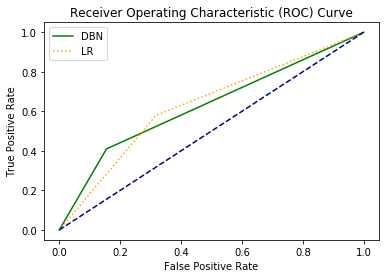

In [11]:
plot_roc_curve(fpr, tpr,fpr_lr,tpr_lr)

In [12]:
auc = roc_auc_score(DBN_expected_y_mozilla, DBN_predicted_y_mozilla)
print('AUC: %.2f' % auc)

auc_lr = roc_auc_score(expected_y_mozilla, predicted_y_mozilla)
print('AUC: %.2f' % auc_lr)

AUC: 0.60
AUC: 0.66


In [13]:
fpr, tpr, thresholds = roc_curve(DBN_expected_y_mozilla, DBN_predicted_y_mozilla)
fpr_lr , tpr_lr , th = roc_curve(expected_y_mozilla,predicted_y_mozilla)

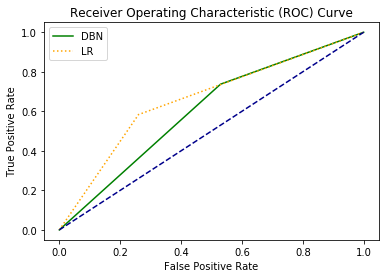

In [14]:
plot_roc_curve(fpr, tpr,fpr_lr,tpr_lr)

In [15]:
auc = roc_auc_score(DBN_expected_y_jdt, DBN_predicted_y_jdt)
print('AUC: %.2f' % auc)

auc_lr = roc_auc_score(expected_y_jdt, predicted_y_jdt)
print('AUC: %.2f' % auc_lr)

AUC: 0.61
AUC: 0.60


In [16]:
fpr, tpr, thresholds = roc_curve(DBN_expected_y_jdt, DBN_predicted_y_jdt)
fpr_lr , tpr_lr , th = roc_curve(expected_y_jdt,predicted_y_jdt)

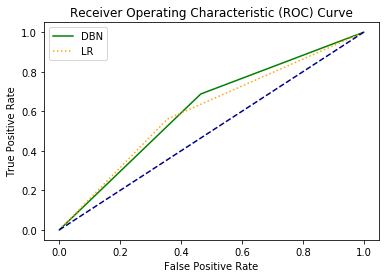

In [17]:
plot_roc_curve(fpr, tpr,fpr_lr,tpr_lr)